In [176]:
import numpy as np
import cv2
import csv
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
from skimage import transform, exposure, color

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, Dropout, MaxPooling2D, Activation, Lambda, Cropping2D
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator



# TODO: 1x1 convolutions to automatically get best color model
# TODO: 0. drive.py sends RGB images to the model; cv2.imread() reads images in BGR format!!!!
# TODO: Horizontal and vertical shifts
# TODO: Data augmentation: brightness



def read_csv():
    csv_data = []
    with open('../SDCND_output/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            csv_data.append(line)
    return csv_data

def read_csv_pd():
    driving_log = pd.read_csv('../SDCND_output/driving_log.csv', header=None,
                           names=['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 
                                  'Throttle', 'Break', 'Speed'])
    return driving_log

def clean_data(driving_log, upper_angle=0.7, zero_frac=0.1):
    # clean the driving log data:
    # 1. remove most but not all samples driving straight to reduce bias of going straight
    # 2. remove samples with large steering angle
    
    a = driving_log.shape[0]
    
    # Safe small number of sample of going straight
    zero_lines = driving_log[driving_log['Steering Angle']==0]
    b = zero_lines.shape[0]
    zero_lines_sample = zero_lines.sample(frac=zero_frac, random_state=42)
    c = zero_lines_sample.shape[0]
    
    # Drop all samples of driving straight
    driving_log = driving_log[driving_log['Steering Angle'] != 0]
    d = driving_log.shape[0]
    
    # Drop samples with large steering angles left and right
    driving_log = driving_log[driving_log['Steering Angle'] < upper_angle]
    driving_log = driving_log[driving_log['Steering Angle'] >- upper_angle]
    e = driving_log.shape[0]
    
    # Add some samples of driving straight back in
    driving_log = pd.concat([driving_log, zero_lines_sample])
    f = driving_log.shape[0]
    
    # Print statistics
    print('Number of samples in input data:', a)
    print('Number of samples going straight:', b)
    print('Number of random samples going straight that are kept (', zero_frac*100, '% ):', c)
    print('Number of samples without samples going straight:', d)
    print('Without samples with large steering angles ( +-', upper_angle, '):', e)
    print('Number of samples with rescued samples: ', f)
    
    return driving_log
    
def import_pictures(csv_data, steering_correction=0.25):
    images = []
    steering_angle = []
    for line in csv_data:
        # Center image
        image_path = '../SDCND_output/IMG/' + line[0].split('\\')[-1]
        images.append(img_to_array(load_img(image_path)))
        steering_angle.append(float(line[3]))
        # Left image
        #image_path = '../SDCND_output/IMG/' + line[1].split('\\')[-1]
        #images.append(load_img(image_path))
        #steering_angle.append(float(line[3]) + steering_correction)
        # Right image
        #image_path = '../SDCND_output/IMG/' + line[2].split('\\')[-1]
        #images.append(load_img(image_path))
        #steering_angle.append(float(line[3]) - steering_correction)

    X_train = np.array(images)
    y_train = np.array(steering_angle)
    print('After import shape X_train: ', X_train.shape, ',  Shape y_train: ', y_train.shape)

    return X_train, y_train


def augment_pictures(X_train, y_train):
    print('Before Shape X_train: ', X_train.shape, ',  Shape y_train: ', y_train.shape)

    X_aug, y_aug = [], []
    for X, y in zip(X_train, y_train):
        X_aug.append(X)
        y_aug.append(y)
        X_aug.append(cv2.flip(X, 1))
        y_aug.append(y * -1.0)

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    print('After Shape X_train: ', X_aug.shape, ',  Shape y_train: ', y_aug.shape)

    return X_aug, y_aug


def load_image(sample, rand=0.5, steering_correction=0.25):
    steering_angle = float(sample[3])
    if rand < 1/3: 
        # Left image
        image_path = '../SDCND_output/IMG/' + sample[1].split('\\')[-1]
        steering_angle += steering_correction
    elif rand > 2/3:
        # Right image
        image_path = '../SDCND_output/IMG/' + sample[2].split('\\')[-1]
        steering_angle -= steering_correction
    else: 
        # Center image
        image_path = '../SDCND_output/IMG/' + sample[0].split('\\')[-1]

    # Load image and steering angle
    image = load_img(image_path)
    return image, steering_angle


def flip_image(img, angle, rand=1):
    if rand < 1/2:
        img  = np.fliplr(img)
        angle = angle * -1.0
    return img, angle

    
def brightness_image(img, rand=0.5):
    img_hsv = color.rgb2hsv(img)
    adj = 1.2
    img_hsv[:,:,2] = img_hsv[:,:,2] * adj
    img = color.hsv2rgb(img_hsv)
    return img


def v_shift_image(img, rand=0.5):
    if rand < 1/3:
        tform = transform.AffineTransform(rotation=0, shear=0, translation = (0, 20))
        img = transform.warp(img, tform)
    elif rand > 2/3:
        tform = transform.AffineTransform(rotation=0, shear=0, translation = (0, -20))
        img = transform.warp(img, tform)
    return img


def h_shift_image(img, rand=0.5):
    if rand < 1/3:
        tform = transform.AffineTransform(rotation=0, shear=0, translation = (20, 0))
        img = transform.warp(img, tform)
    elif rand > 2/3:
        tform = transform.AffineTransform(rotation=0, shear=0, translation = (-20, 0))
        img = transform.warp(img, tform)
    return img

    
    
def print_histogram(data):
    plt.figure(figsize=(17,7))
    plt.hist(data, bins=81)
    #plt.xticks( np.arange(n_classes) )
    #plt.xticks(np.arange(n_classes), np.bincount(y_train))
    plt.xlabel('Steering angle')
    plt.ylabel('Number of samples')
    plt.show()
    return

# X_train, y_train = import_pictures()

def generator(data, augments_per_image=8, batch_size=32):
    nb_data = len(data)
    while 1:
        shuffle(data)
        for offset in range(0, nb_data, batch_size):
            batch_samples = data[offset:offset + batch_size]

            images = []
            steering_angles = []
            for batch_sample in batch_samples:
                for n in range(augments_per_image):
                        # Run randomizer to determine what kind of augmentation is used.
                        # There are 4 kinds of augmentations with 3 ways each
                        # 1. Camera: left image | center image | right image
                        # 2. Flip: normal | flipped 
                        # 3. Horizontal shift: left | normal | right
                        # 4. Vertical shift: up | normal | down
                        # 5. Brightness: bright | normal | dark
                        
                        rand = np.random.random(5)
                        
                        # 1. Camera: left image | center image | right image
                        image, steering_angle = load_img(batch_sample, rand[0])
                        
                        # 2. Flip: normal | flipped 
                        image, steering_angle = flip_image(image, steering_angle, rand[1])
                        
                        # 3. Horizontal shift: left | normal | right
                        image = h_shift_image(image, rand[2])
                        
                        # 4. Vertical shift: up | normal | down
                        image = v_shift_image(image, rand[3])
                        
                        # 5. Brightness: bright | normal | dark
                        image = brightness_image(image, rand[4])
                    
                        images.append(image)
                        steering_angles.append(steering_angle)

            X_train = np.array(images)
            y_train = np.array(steering_angle)
            yield shuffle(X_train, y_train)

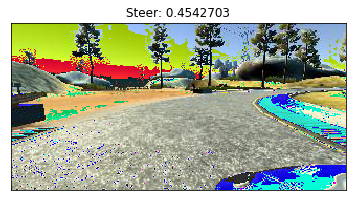

In [177]:
driving_log = read_csv_pd()

plt.figure()
index = random.randint(0, 200)
image, steering_angle = load_image(driving_log.loc[85], 0.9)
image, steering_angle = flip_image(image, steering_angle, 0.1)
image = brightness_image(image)
plt.xticks([]), plt.yticks([])
plt.imshow(image, cmap="gray")
plt.title('Steer: ' + str(steering_angle))
    
plt.show()

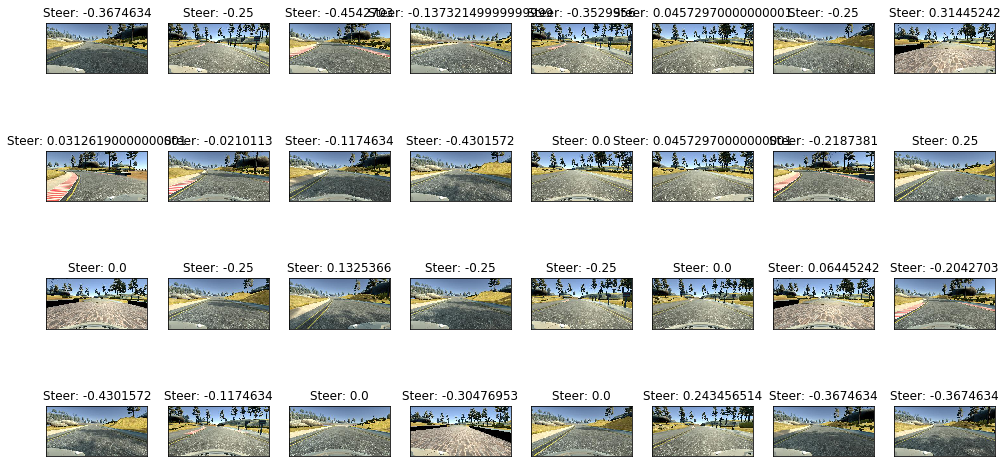

In [114]:
driving_log = read_csv_pd()
image, steering_angle = load_image(driving_log.loc[85], rand = 0.1)


plt.figure(figsize=(17,9))

for n in range(32):
    index = random.randint(0, 200)
    image, steering_angle = load_image(driving_log.loc[index], random.random())
    plt.subplot(4,8,n+1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(image, cmap="gray")
    plt.title('Steer: ' + str(steering_angle))
    
plt.show()

#print(driving_log.loc[27])


In [74]:
print(np.random.randint(3, size=5))

[0 2 2 2 2]


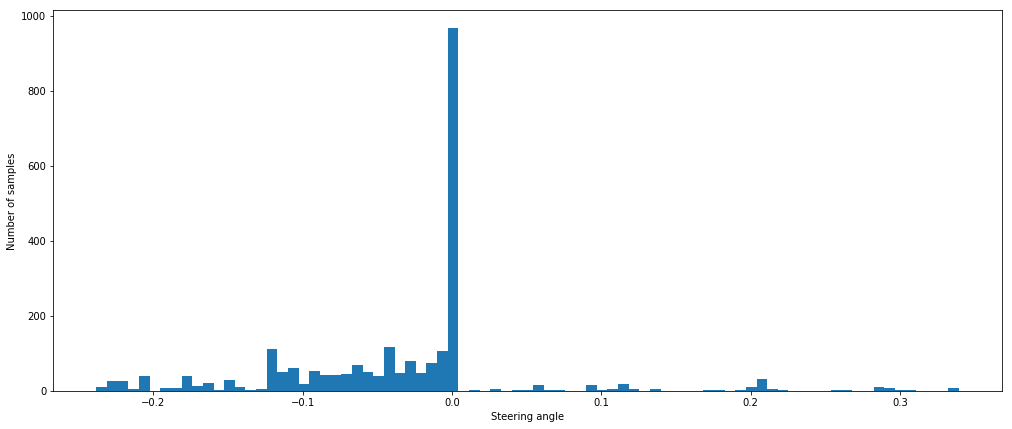

Number of samples in input data: 2416
Number of samples going straight: 920
Number of random samples going straight that are kept ( 10.0 % ): 92
Number of samples without samples going straight: 1496
Without samples with large steering angles ( +- 0.5 ): 1496
Number of samples with rescued samples:  1588


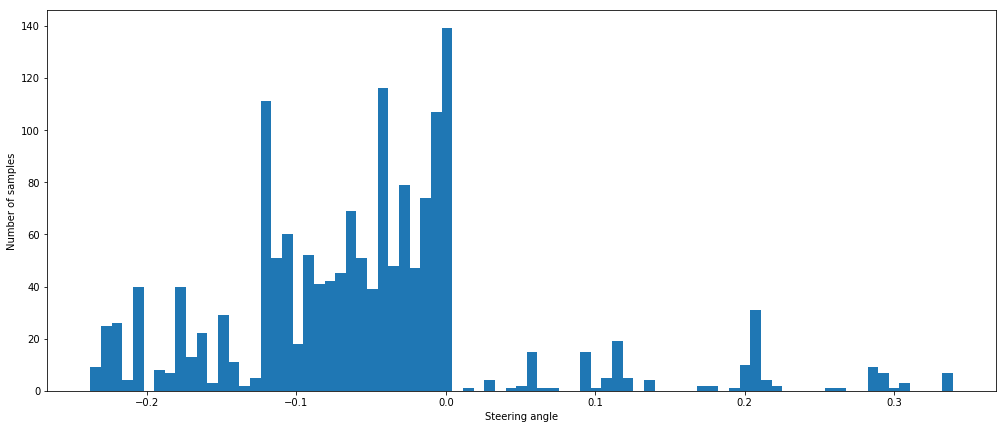

In [45]:
driving_log = read_csv_pd()
print_histogram(driving_log['Steering Angle'].values)
driving_log = clean_data(driving_log, upper_angle=0.5, zero_frac=0.1)
print_histogram(driving_log['Steering Angle'].values)

In [235]:
csv_data = read_csv()
train_samples, validation_samples = train_test_split(csv_data, test_size=0.2)

y_train = np.array(csv_data[3])
#X_train, y_train = import_pictures(csv_data)
#X_train, y_train = augment_pictures(X_train, y_train)

In [ ]:
def nvidia_model(X_train, y_train, EPOCHS=5):
    model = Sequential()
    model.add(Cropping2D(cropping=((62, 25), (0, 0)), input_shape=(160, 320, 3)))
    model.add(Lambda(lambda x: x / 255.0 - 0.5))

    model.add(Conv2D(24, 5, 5, subsample=(2, 2), activation='relu'))
    model.add(Conv2D(36, 5, 5, subsample=(2, 2), activation='relu'))
    model.add(Conv2D(48, 5, 5, subsample=(2, 2), activation='relu'))
    model.add(Conv2D(64, 3, 3, subsample=(1, 1), activation='relu'))
    model.add(Conv2D(64, 3, 3, subsample=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=EPOCHS, verbose=1)

    model.save('model.h5')

    ### print the keys contained in the history object
    print(history_object.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

In [53]:
# Keras data augmentation gen
datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('../SDCND_output/IMG/center_2017_07_18_12_37_19_118.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(X_train, batch_size=32,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 1:
        break  # otherwise the generator would loop indefinitely

FileNotFoundError: [Errno 2] No such file or directory: '../SDCND_output/IMG/center_2017_07_18_12_37_19_118.jpg'

In [222]:
driving_log = read_csv_pd()

y_2 = driving_log['Steering Angle']
print(driving_log.shape)
hist = np.histogram(y_train, bins=50)[0]
print(np.sort(hist))
print(np.sort(hist)[-2])
print(np.percentile(hist, 95))

#print(driving_log['Steering Angle'].value_counts(bins=20))

test = driving_log[driving_log['Steering Angle'] != 0]
print(test.shape)


zero_lines = driving_log[driving_log['Steering Angle']==0]
print(zero_lines.shape)

zero_lines_sample = zero_lines.sample(frac=0.1, random_state=42)
print(zero_lines_sample.shape)

zeros_index = driving_log.index[driving_log['Steering Angle']==0]
driving_log = driving_log.drop(zeros_index)
print(driving_log.shape)
print(zero_lines_sample.shape)
driving_log = pd.concat([driving_log, zero_lines_sample])
print(driving_log.shape)

max_index = driving_log.index[driving_log['Steering Angle']>0.15]
driving_log = driving_log.drop(max_index)
print(driving_log.shape)

min_index = driving_log.index[driving_log['Steering Angle']<-0.15]
driving_log = driving_log.drop(min_index)
print(driving_log.shape)
#print(driving_log.index[driving_log['Steering Angle'] == 0])
#y_train_no_zero = driving_processed['Steering Angle'].values

y_train = driving_log['Steering Angle'].values

(2416, 7)
[  0   0   0   0   0   0   0   0   0   1   1   1   1   1   1   2   2   3
   3   4   5   5   5   6   9  13  14  15  16  18  21  22  25  29  31  31
  35  37  37  42  48  64  69  71  83  84  91  91 107 139]
107
91.0
(1496, 7)
(920, 7)
(92, 7)
(1496, 7)
(92, 7)
(1588, 7)
(1507, 7)
(1283, 7)
